In [1]:
import os
import copy
import random

from PIL import Image, ImageFont, ImageDraw, ImageColor

import numpy as np
import torch

import matplotlib.pyplot as plt
import matplotlib as mpl
import networkx as nx

from pytorch_pretrained_bert.tokenization import BertTokenizer
from pytorch_pretrained_bert.model_attr import BertForSequenceClassification
from examples.classifier_processer import InputExample, InputFeatures, DataProcessor, MnliProcessor

from utils import convert_examples_to_features, scaled_input

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
SEED = 42

In [3]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


seed_everything(seed=SEED)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize

In [5]:
processor = MnliProcessor()
label_list = processor.get_labels()
num_labels = len(label_list)

In [6]:
MODEL_NAME = 'bert-base-cased'

In [7]:
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME, do_lower_case=False)

In [8]:
MODEL_FILENAME = '../model_and_data/model.mnli.bin'

In [9]:
model_state_dict = torch.load(MODEL_FILENAME, map_location=device)
model = BertForSequenceClassification.from_pretrained(
    MODEL_NAME, state_dict=model_state_dict, num_labels=num_labels)
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
          

In [10]:
num_head, num_layer = 12, 12

In [11]:
DATA_PATH = '../model_and_data/mnli_data'

In [12]:
eval_segment = 'diagnostic'
example_index = 128
eval_examples = [processor.get_test_examples(DATA_PATH, segment=eval_segment)[example_index]]

model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
          

In [13]:
eval_examples[0].text_a, eval_examples[0].text_b, eval_examples[0].label

('Cape sparrows eat seeds, along with soft plant parts and insects.',
 'Cape sparrows are eaten.',
 'contradiction')

# Calculate attr score

In [14]:
res_attr = []
att_all = []

In [15]:
MAX_SEQ_LEN = 128
BATCH_SIZE = 1
NUM_BATCH = 1

In [16]:
eval_features, tokenlist = convert_examples_to_features(eval_examples, label_list, MAX_SEQ_LEN, tokenizer)
print(f"***** Running evaluation: {eval_segment} *****")
print(f"  Num examples = {len(eval_examples)}")
print(f"  Batch size = {BATCH_SIZE}")
eval_feature = eval_features[0]

*** Example ***
guid: diagnostic-128
tokens: [CLS] Cape spa ##rrows eat seeds , along with soft plant parts and insects . [SEP] Cape spa ##rrows are eaten . [SEP]
input_ids: 101 4343 22620 24847 3940 8365 117 1373 1114 2991 2582 2192 1105 9895 119 102 4343 22620 24847 1132 8527 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

In [17]:
tokenlist

[{'token': ['[CLS]',
   'Cape',
   'spa',
   '##rrows',
   'eat',
   'seeds',
   ',',
   'along',
   'with',
   'soft',
   'plant',
   'parts',
   'and',
   'insects',
   '.',
   '[SEP]',
   'Cape',
   'spa',
   '##rrows',
   'are',
   'eaten',
   '.',
   '[SEP]'],
  'golden_label': 'contradiction',
  'pred_label': None}]

In [18]:
input_ids = torch.tensor([eval_feature.input_ids], dtype=torch.long).to(device)
input_mask = torch.tensor([eval_feature.input_mask], dtype=torch.long).to(device)
segment_ids = torch.tensor([eval_feature.segment_ids], dtype=torch.long).to(device)
label_ids = torch.tensor([eval_feature.label_id], dtype=torch.long).to(device)
input_len = int(input_mask[0].sum())

In [19]:
for tar_layer in range(num_layer):
    att, baseline_logits = model(input_ids, segment_ids, input_mask, label_ids, tar_layer)
    pred_label = int(torch.argmax(baseline_logits))
    att_all.append(att.data)

    scale_att, step = scaled_input(att.data, BATCH_SIZE, NUM_BATCH)
    scale_att.requires_grad_(True)

    attr_all = None
    prob_all = None
    for j_batch in range(NUM_BATCH):
        one_batch_att = scale_att[j_batch * BATCH_SIZE:(j_batch + 1) * BATCH_SIZE]
        tar_prob, grad = model(input_ids, segment_ids, input_mask, label_ids, tar_layer, one_batch_att,
                               pred_label=pred_label)
        grad = grad.sum(dim=0)
        attr_all = grad if attr_all is None else torch.add(attr_all, grad)
        prob_all = tar_prob if prob_all is None else torch.cat([prob_all, tar_prob])
    attr_all = attr_all[:, 0:input_len, 0:input_len] * step[:, 0:input_len, 0:input_len]
    res_attr.append(attr_all.data)

/Users/stepantytarenko/Sandbox/Projects/attattr/pytorch_pretrained_bert/model_attr.py:1026: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob = torch.nn.functional.softmax(logits)


In [20]:
np.array(res_attr).shape

(12, 12, 23, 23)

In [21]:
attr_all.shape

torch.Size([12, 23, 23])

In [22]:
att[:, :input_len, :input_len].shape

torch.Size([12, 23, 23])

In [23]:
labels = [token for token in tokenlist[0]['token']]

In [24]:
def plot_parallel(matrix):
    # Set figsize
    plt.figure(figsize=(12, 8))

    # Vertical lines for the years
    plt.axvline(x=1, color='black', linestyle='--', linewidth=1)
    plt.axvline(x=5, color='black', linestyle='--', linewidth=1)

    # Add the BEFORE and AFTER
    plt.text(1, input_len + 1, 'A', fontsize=12, color='black', fontweight='bold')
    plt.text(5, input_len + 1, 'B', fontsize=12, color='black', fontweight='bold')

    # Plot the line for each continent
    for i in range(input_len):
        for j in range(input_len):
            # Add the line to the plot
            plt.plot([1, 5], [i, j], marker='o', label='token', color='blue', linewidth=5 * matrix[i][j])

            # Add label of each continent at each year
            plt.text(
                1 - 0.18,  # x-axis position
                i,  # y-axis position
                tokenlist[0]['token'][i],  # Text
                fontsize=8,  # Text size
                color='black',  # Text color,
            )

            plt.text(
                5 + 0.06,  # x-axis position
                j,  # y-axis position
                tokenlist[0]['token'][j],  # Text
                fontsize=8,  # Text size
                color='black',  # Text color
            )

    # Add a title ('\n' allow us to jump lines)
    plt.title(f'AttrAttr scores \n\n\n')

    plt.yticks([])  # Remove y-axis
    plt.box(False)  # Remove the bounding box around plot
    plt.show()  # Display the chart

In [25]:
att_matrix = att[1, :input_len, :input_len].detach().numpy()

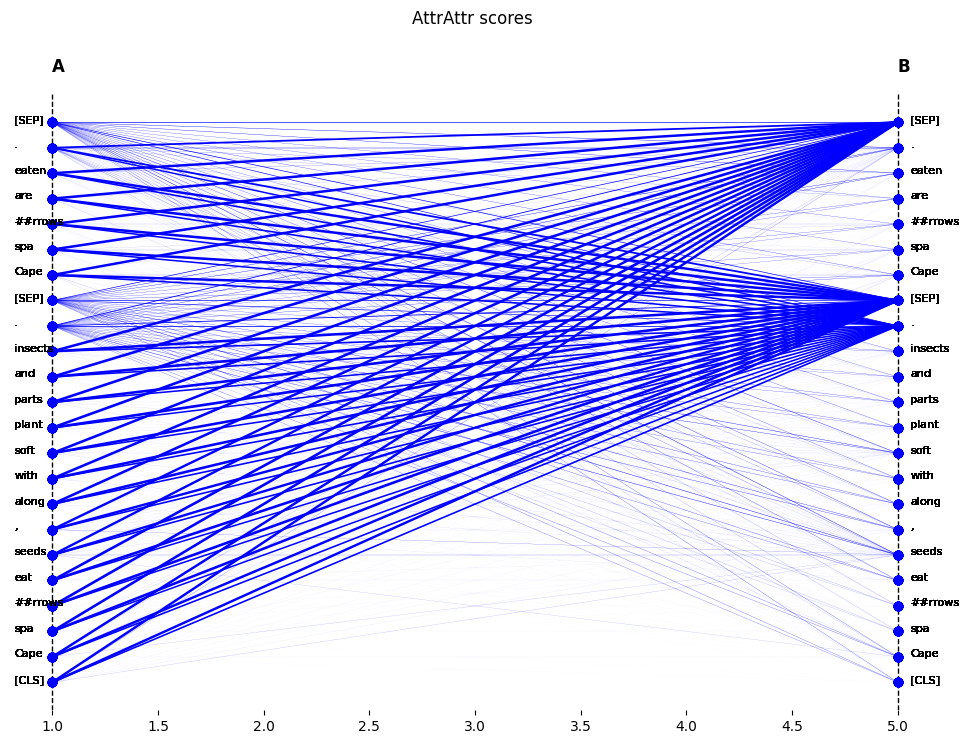

In [26]:
plot_parallel(att_matrix)

In [27]:
attr_matrix = attr_all[1, :input_len, :input_len].detach().numpy()
attr_matrix = attr_matrix / attr_matrix.sum()

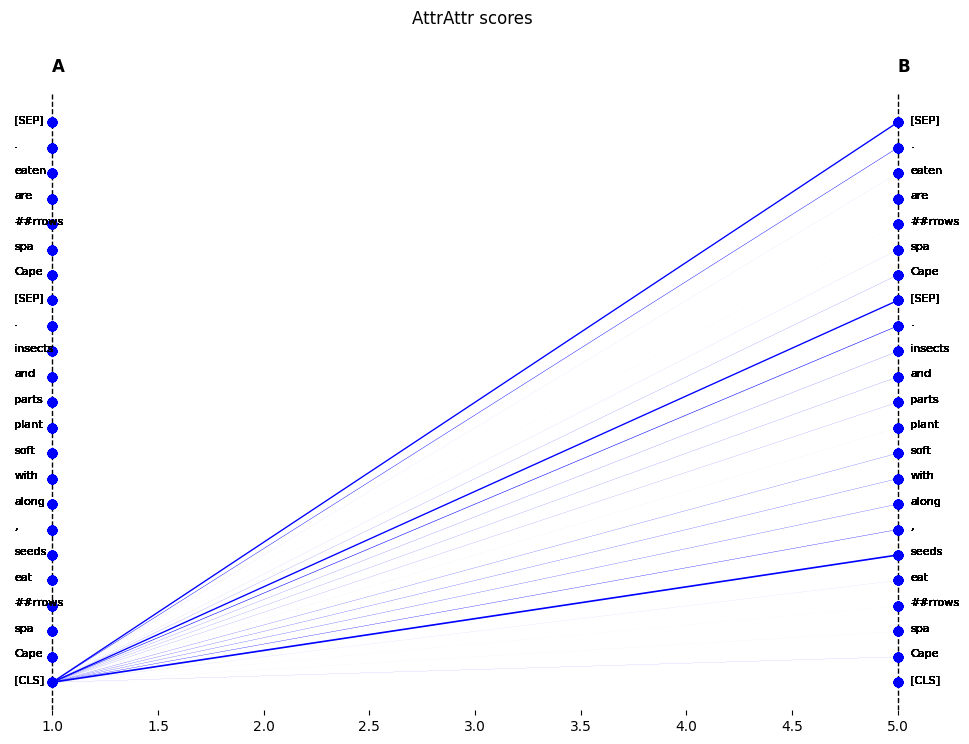

In [28]:
plot_parallel(attr_matrix)

# Calculate Adversarial Connection

In [29]:
saved_res = []
tokens = tokenlist[0]['token']
tokens

['[CLS]',
 'Cape',
 'spa',
 '##rrows',
 'eat',
 'seeds',
 ',',
 'along',
 'with',
 'soft',
 'plant',
 'parts',
 'and',
 'insects',
 '.',
 '[SEP]',
 'Cape',
 'spa',
 '##rrows',
 'are',
 'eaten',
 '.',
 '[SEP]']

In [30]:
seg_pos = tokens.index('[SEP]')
tar_head_attr = None

In [31]:
att, baseline_logits = model(input_ids, segment_ids, input_mask, label_ids, tar_layer=-1)
pred_label = int(torch.argmax(baseline_logits))

In [32]:
for tar_layer in range(0, num_layer):
    baseline = None
    scale_att, step = scaled_input(att.data, BATCH_SIZE, NUM_BATCH, baseline)
    scale_att.requires_grad_(True)

    attr_all = None
    for j_batch in range(NUM_BATCH):
        one_batch_att = scale_att[j_batch * BATCH_SIZE:(j_batch + 1) * BATCH_SIZE]
        tar_prob, grad = model(input_ids, segment_ids, input_mask, label_ids,
                               tar_layer, one_batch_att, pred_label=pred_label)
        grad = grad.sum(dim=0)
        attr_all = grad if attr_all is None else torch.add(attr_all, grad)
    attr_all = attr_all[:, 0:input_len, 0:input_len] * step[:, 0:input_len, 0:input_len]
    tar_head_index = int(torch.argmax(attr_all.reshape(num_head * input_len * input_len))) // (input_len * input_len)

    if tar_head_attr is None:
        tar_head_attr = attr_all[tar_head_index]
    else:
        if attr_all[tar_head_index].max() > tar_head_attr.max():
            tar_head_attr = attr_all[tar_head_index]

In [33]:
attr_max = tar_head_attr.cpu().numpy().reshape(input_len * input_len)
attr_sorted_index = np.argsort(attr_max)[::-1]  # reverse order
saved_res.append({
    "max_combined_attr": [float(attr_max[attr_sorted_index[0]]), float(attr_max[attr_sorted_index[1]])],
    "top1pattern": [tokens[attr_sorted_index[0] // input_len], tokens[attr_sorted_index[0] % input_len]],
    "top2pattern": [tokens[attr_sorted_index[1] // input_len], tokens[attr_sorted_index[1] % input_len]],
    "top1position": [int(attr_sorted_index[0] // input_len), int(attr_sorted_index[0] % input_len)],
    "top2position": [int(attr_sorted_index[1] // input_len), int(attr_sorted_index[1] % input_len)],
    "target_label": pred_label,
    "golden_label": int(label_ids[0]),
    "tokens": tokens
})

saved_res

[{'max_combined_attr': [0.014560938812792301, 0.010752285830676556],
  'top1pattern': ['seeds', '[CLS]'],
  'top2pattern': ['seeds', '.'],
  'top1position': [5, 0],
  'top2position': [5, 14],
  'target_label': 2,
  'golden_label': 0,
  'tokens': ['[CLS]',
   'Cape',
   'spa',
   '##rrows',
   'eat',
   'seeds',
   ',',
   'along',
   'with',
   'soft',
   'plant',
   'parts',
   'and',
   'insects',
   '.',
   '[SEP]',
   'Cape',
   'spa',
   '##rrows',
   'are',
   'eaten',
   '.',
   '[SEP]']}]

In [34]:
attack = saved_res[0]

In [35]:
def generate_text_highlighted(attack, canvas=(450, 300)):
    im = Image.new(mode='RGBA', size=canvas, color=(255, 255, 255, 255))

    img = ImageDraw.Draw(im)

    def highlight(xy, wh, color):
        img.rectangle(xy=(xy[0] - 0.5, xy[1] - 0.5, xy[0] + wh[0], xy[1] + wh[1]), fill=color) # , outline='red'

    # highlight((28, 36), wh=(5, 12), color=(255, 0, 0, 100))
    # img.text((28, 36), 'nice Car', fill=(0, 0, 0, 200))

    x = 28
    y = 36
    for i, token in enumerate(attack['tokens']):
        if i in attack['top1position']:
            highlight((x, y), wh=(6 * len(token), 12), color=(255, 0, 0, 100))
            img.text((x, y), token, fill=(0, 0, 0, 200))
        elif i in attack['top2position']:
            highlight((x, y), wh=(6 * len(token), 12), color=(0, 0, 255, 100))
            img.text((x, y), token, fill=(0, 0, 0, 200))
        else:
            img.text((x, y), token, fill=(0, 0, 0, 255))

        x += 1.4 * 5 * len(token)
        if x >= canvas[0]:
            x = 28
            y += 1.4 * 7

    return im

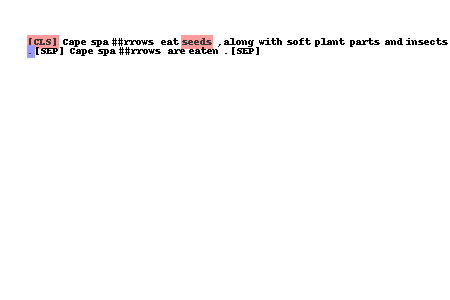

In [36]:
generate_text_highlighted(attack)

# Attribution Tree

In [37]:
attr_all = np.array(res_attr).sum(1)
eps = 1e-8
proportion_all = copy.deepcopy(attr_all)
for i in range(len(proportion_all)):
    proportion_all[i] /= abs(proportion_all[i][1:,:].max() + eps)
proportion_all

array([[[ 1.48407832e-01, -3.27743329e-02, -9.80917644e-03, ...,
         -5.93353547e-02, -3.27114984e-02, -1.52675703e-01],
        [ 4.32808809e-02, -3.05562783e-02,  1.84803810e-02, ...,
         -1.63908750e-02, -6.65931311e-03,  6.71970006e-03],
        [ 1.78909805e-02,  2.15671230e-02,  6.89649628e-03, ...,
          1.78991281e-03, -1.22500788e-02, -1.20450705e-02],
        ...,
        [-7.79512674e-02,  5.81874438e-02, -1.17663398e-01, ...,
         -2.05091536e-01,  8.45127553e-02,  6.35216475e-01],
        [-2.01927125e-02, -5.18308114e-03, -4.23824601e-03, ...,
         -8.34400672e-03, -3.98211740e-02,  3.83926868e-01],
        [-1.13888141e-02, -1.87726656e-03, -1.02861831e-02, ...,
          3.60542705e-04,  1.79684669e-01,  1.62595242e-01]],

       [[ 2.24144444e-01,  7.34743616e-03, -1.74580216e-02, ...,
          8.49551242e-03, -7.45445769e-03,  4.64004874e-02],
        [ 3.98449525e-02,  1.17735453e-02,  2.60893166e-01, ...,
         -4.65400890e-03, -2.77594775e

In [38]:
# adjust the threshold
threshold = 0.4
proportion_all *= (proportion_all > threshold).astype(int)

In [39]:
seq_length = len(proportion_all[0])
height_list = [0 for i in range(seq_length)]
# -1: not appear  0: appear but not fixed  1: fixed
fixed_list = [-1 for i in range(seq_length)]
edges = []

In [40]:
# find the top node
ig_remain = [0 for i in range(seq_length)]
att_combine_layer = attr_all.sum(0) / abs(attr_all.sum(0).max())
att_combine_layer *= (1 - np.identity(len(att_combine_layer))) * (att_combine_layer > 0)
att_combine_layer[0] *= 0
arg_res = np.argsort(att_combine_layer.sum(-1))[::-1]

In [41]:
top_token_index = arg_res[0] if arg_res[0] != 0 else arg_res[1]
height_list[top_token_index] = 11/12
fixed_list[top_token_index] = 0
for i in range(seq_length):
    if i != top_token_index and proportion_all[10][top_token_index][i] > threshold:
        fixed_list[i] = 0
        fixed_list[top_token_index] = 1
        edges.append((top_token_index, i))

In [42]:
for layer_index in range(9, -1, -1):
    for i_token in range(1, seq_length):
        for j_token in range(0, seq_length):
            if proportion_all[layer_index][i_token][j_token] < threshold or fixed_list[i_token] == -1:
                continue
            if fixed_list[j_token] == 1:
                continue
            if (i_token, j_token) in edges:
                continue
            if fixed_list[i_token] == 0 and fixed_list[j_token] == 0:
                continue
            if fixed_list[i_token] == 1 and fixed_list[j_token] == 0:
                continue
            if fixed_list[i_token] == 0 and fixed_list[j_token] == -1:
                fixed_list[i_token] = 1
                fixed_list[j_token] = 0
                height_list[j_token] = ((height_list[i_token]) * 12 - 1) / 12
            if fixed_list[i_token] == 1 and fixed_list[j_token] == -1:
                fixed_list[j_token] = 0
                height_list[j_token] = min(height_list)
            edges.append((i_token, j_token))

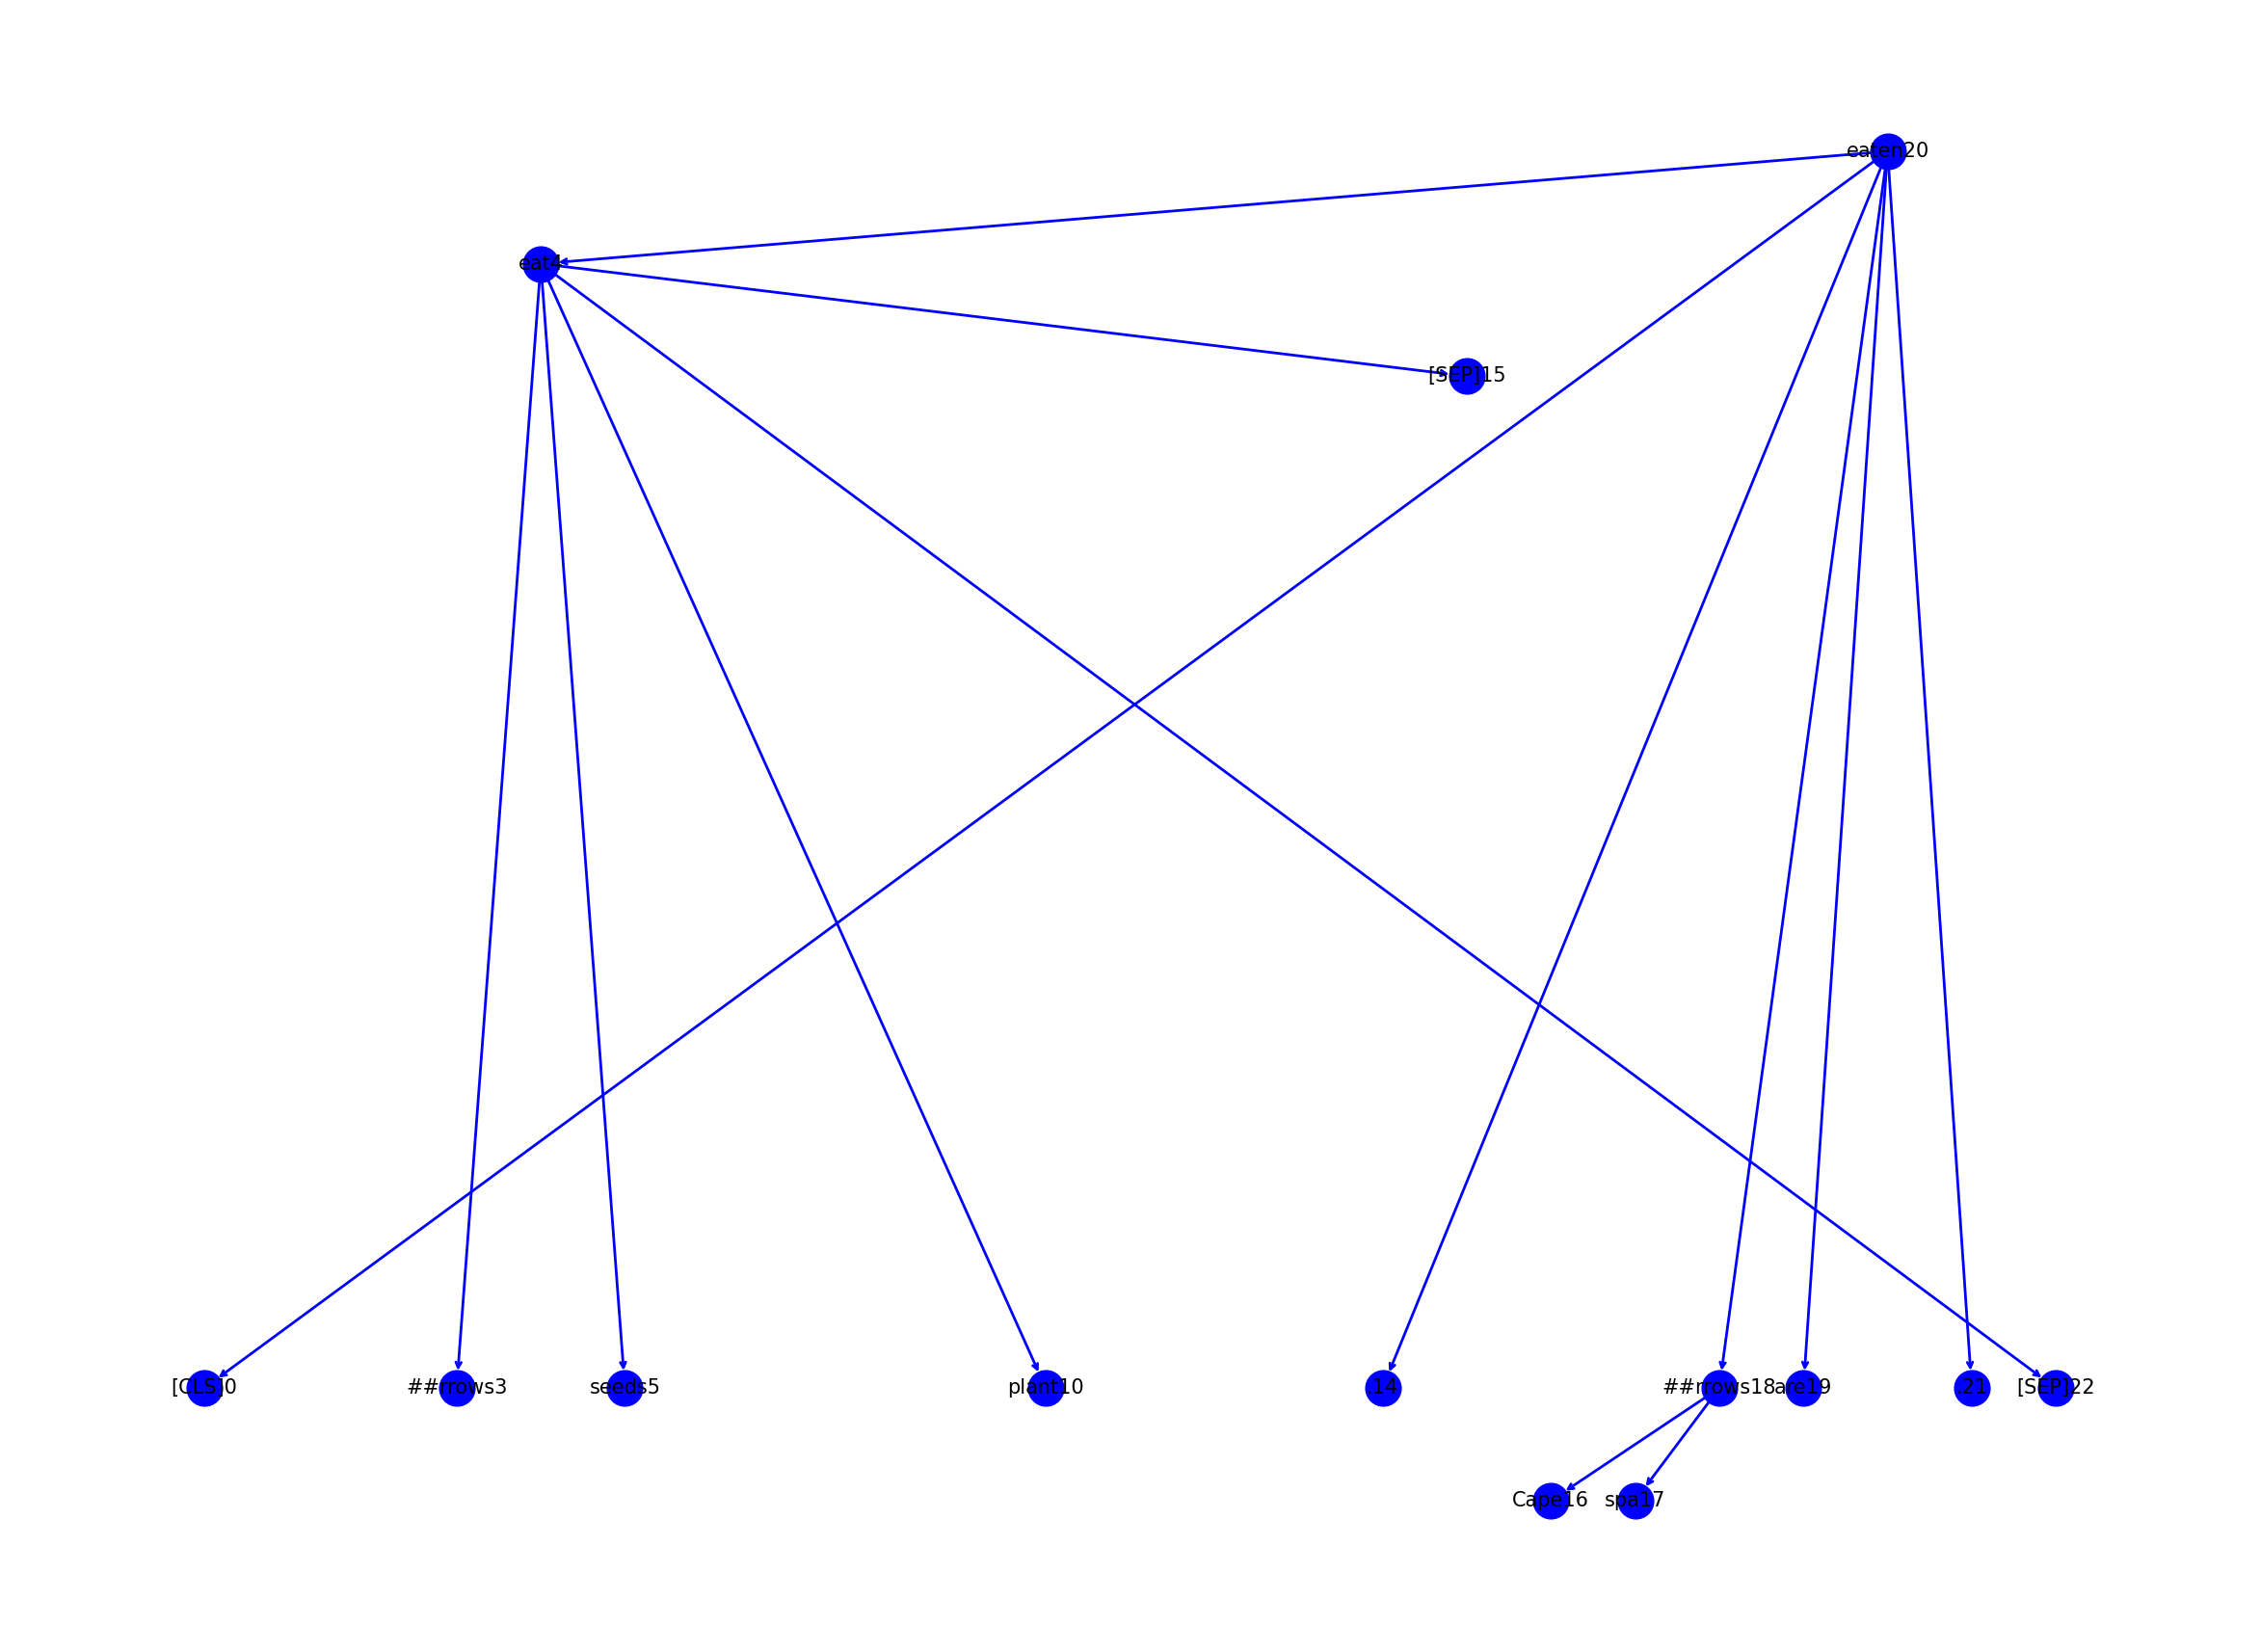

In [43]:
for i in range(len(tokens)):
    tokens[i] = tokens[i] + str(i)

fig1 = plt.figure(1,figsize=(30,22))
fig1.patch.set_facecolor('xkcd:white')

G = nx.DiGraph()

for token in tokens:
    G.add_node(token)

for (i_token, j_token) in edges:
    G.add_weighted_edges_from([(tokens[i_token], tokens[j_token], 0.5)])

fix_position = {tokens[i]:[i/len(tokens), height_list[i]] for i in range(len(tokens))}
M = G.number_of_edges()
pos = nx.spring_layout(G, pos=fix_position)
edge_colors = range(2, M + 2)

unused_node = list(nx.isolates(G))
for node in unused_node:
    G.remove_node(node)

edge_alphas = []
edges_list = list(G.edges.data())
for single_edge in edges_list:
    edge_alphas.append(single_edge[2]["weight"])

nodes = nx.draw_networkx_nodes(G, fix_position, node_size=700, node_color='blue')
edges = nx.draw_networkx_edges(G, fix_position, node_size=700, arrowstyle='->',
                            arrowsize=10, edge_color='b',
                            edge_cmap=plt.cm.Blues, width=2)
nx.draw_networkx_labels(G, fix_position, font_size=15, font_family='sans-serif')

pc = mpl.collections.PatchCollection(edges, cmap=plt.cm.Blues)
pc.set_array(edge_colors)

ax = plt.gca()
ax.set_axis_off()
plt.show()